# Single-Qubit Quantum State Tomography Experiment
## **WMI Quantum Computer**

This experiment aims to implement a single-qubit quantum state tomography process using one of the WMI Quantum Computer backends (i.e. actual quantum hardware). By using a gradient descent algorithm, the experimentation flow consists of 3 main stages: initialization, training, and testing. The goal is to train the rotation angles that should be applied to the Bloch Sphere (i.e. qubit) by using a universal rotation quantum gate, in order to get a certain randomly pre-generated quantum state.

## Set-up

In [1]:
# Set-up: Python package dependencies
%pip install matplotlib
%pip install qutip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set-up: Python module imports
import matplotlib.pyplot as plt
import numpy as np
import qib
import qutip as qt

from IPython.display import display, HTML

In [3]:
# Experiment Parameters
ACCESS_TOKEN = input("(WMI) Enter API access token: ")
SHOTS = 2**12

In [4]:
# Hyperparameters
LEARNING_RATE = 0.5
MAX_STEPS = 20
CONVERGENCE_THRESHOLD = 0.1

R = 1 # assuming global phase is 1

### Utility Functions

In [5]:
def to_spherical(x: float, y: float, z: float) -> tuple[float, float, float]:
    """Converts cartesian coordinates to spherical coordinates."""
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def to_cartesian(r: float, theta: float, phi: float) -> tuple[float, float, float]:
    """Converts spherical coordinates to cartesian coordinates."""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [6]:
def display_legend(simple: bool = False):
    filename = 'qst_legend_simple.html' if simple else 'qst_legend_full.html'
    with open(filename, 'r') as f:
        display(HTML(f.read()))

## **Stage 1: Initialization**

In this first stage we generate a random quantum state, by generating two random values for the theta and phi rotation angles of the Bloch Sphere's spherical coordinate system. This will be the goal state, that our algorithm should be able to train on and learn in the following stages.

Generated angles: 
theta = 2.000195537915753 ( 114.60 ° ) 
phi = 6.197721699087179 ( 355.10 ° )

Goal state:
x = 0.9058975876966545 
y = -0.07761032448248971 
z = -0.4163246307139474


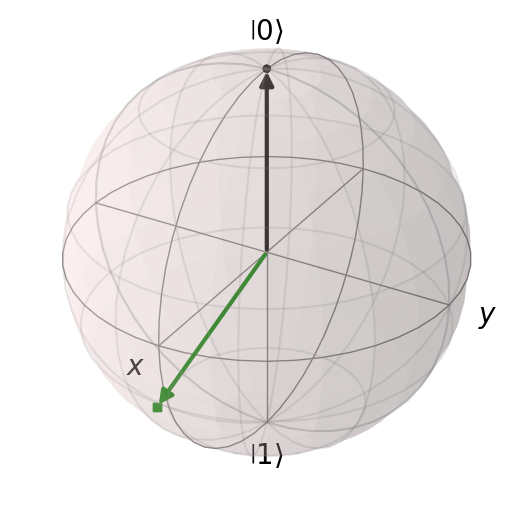

In [7]:
# Generate a random one-qubit state, by applying 2 random angles: theta and phi
spherical_theta_goal: float = 2 * np.pi * np.random.ranf()
spherical_phi_goal: float = 2 * np.pi * np.random.ranf()

# Mathematically determine the state of the qubit, given the angles theta and phi
## i.e. convert from spherical to cartesian coordinates
x_goal, y_goal, z_goal = to_cartesian(R, spherical_theta_goal, spherical_phi_goal)

print('Generated angles:',
      f'\ntheta = {spherical_theta_goal} (', "{0:0.2f}".format(np.rad2deg(spherical_theta_goal)), '° )',
      f'\nphi = {spherical_phi_goal} (', "{0:0.2f}".format(np.rad2deg(spherical_phi_goal)), '° )')
print('\nGoal state:\nx =', x_goal, '\ny =', y_goal, '\nz =', z_goal)

# Bloch Sphere representation
BlochSphere_goal = qt.Bloch()
BlochSphere_goal.add_vectors([0,0,1], colors=['black'])
BlochSphere_goal.add_points([0,0,1], colors=['black'])
BlochSphere_goal.add_vectors([x_goal, y_goal, z_goal], colors=['green'])
BlochSphere_goal.add_points([x_goal, y_goal, z_goal], colors=['green'])
BlochSphere_goal.show()
display_legend(simple=True)

## **Stage 2: Training**

In this stage, we train the rotation angles by using a custom implementation of the gradient descent algorithm. The actual training is achieved through incremental post-rotation quantum measurements and gradient calculations, given a specific learning rate and maximum number of steps. The initial value of the rotation angles is set to the correspondent ground state of the qubit (i.e. `[0,0,0]`):

In [8]:
# Experiment Submission & Scaled Results Counts Average
field = qib.field.Field(qib.field.ParticleType.QUBIT, qib.lattice.IntegerLattice((1,)))
qubit = qib.field.Qubit(field, 0)

processor = qib.backend.wmi.WMIQCProcessor(access_token=ACCESS_TOKEN)
options = qib.backend.wmi.WMIOptions(
    shots=SHOTS,
    init_qubits=True)

def get_experiment_scaled_results_avg(circuit: qib.Circuit) -> float:
    experiment = processor.submit_experiment(
        name = 'qib-quantum-state-tomography',
        circ = circuit,
        options = options)
    results = experiment.results()
    try:
        counts_0 = results.get_counts().get('0', 0)
        counts_1 = results.get_counts().get('1', 0)
        scaled_avg = (counts_0 * 1 + counts_1 * -1) / SHOTS
        return scaled_avg
    except Exception as e:
        print(f'[ERROR] Corrupted experiment results. Experiment Status: {experiment.status}. Error Message: {e}')
        print(f'[DEBUG] Experiment Job ID: {experiment.job_id}')
        return 0

### Universal Rotation Gate Decomposition

$U3(\theta,\phi,\lambda) = RZ(\phi+\pi).SX.RZ(\theta+\pi).SX.RZ(\lambda)$

### Post Rotation Measurements
The proper post-rotation measurements for the:
- X-Basis: `[H]-[Measure]` decomposes to `[Rz(π/2)]-[Sx]-[Rz(π/2)]-[Measure]`
- Y-Basis: `[H]-[Sdg]-[Measure]` decomposes to `[Sx]-[Rz(π/2)]-[Measure]`
- Z-Basis: `[Measure]`

In [9]:
# Circuit Functions
def u3_circuit(theta: float, phi: float, lam: float) -> qib.Circuit:
    return qib.Circuit([
        qib.RzGate(lam, qubit),
        qib.SxGate(qubit),
        qib.RzGate(theta + np.pi, qubit),
        qib.SxGate(qubit),
        qib.RzGate(phi + np.pi, qubit),
    ])

def pauli_x(theta: float, phi: float, lam: float) -> float:
    circuit = u3_circuit(theta, phi, lam)
    circuit.append_circuit(qib.Circuit([
        qib.RzGate(np.pi / 2, qubit),
        qib.SxGate(qubit),
        qib.RzGate(np.pi / 2, qubit),
        qib.MeasureInstruction([qubit])
    ]))
    return get_experiment_scaled_results_avg(circuit)

def pauli_y(theta: float, phi: float, lam: float) -> float:
    circuit = u3_circuit(theta, phi, lam)
    circuit.append_circuit(qib.Circuit([
        qib.SxGate(qubit),
        qib.RzGate(np.pi / 2, qubit),
        qib.MeasureInstruction([qubit])
    ]))
    return get_experiment_scaled_results_avg(circuit)

def pauli_z(theta: float, phi: float, lam: float) -> float:
    circuit = u3_circuit(theta, phi, lam)
    circuit.append_circuit(qib.Circuit([
        qib.MeasureInstruction([qubit])
    ]))
    return get_experiment_scaled_results_avg(circuit)

### Gradient Calculation

Cost function $F = \sum_{k \in \{x, y, z\}}{u_k^2}$, where $u_k(k_{goal}, k_{current}) = k_{goal} - k_{current}$, for $k \in \{x, y, z\}$

$\nabla{F} = ({dF \over d\theta}, {dF \over d\phi}, {dF \over d\lambda})$

**1. $\theta$ Partial Derivative:** ${dF \over d\theta} = {dF \over du} * {du \over d\theta} = (-2u_x * T_x) + (-2u_y * T_y) + (-2u_z * T_z)$
<br>, where $T_k = 1/2 * [\langle Pauli_k(\theta_{current} + \pi/2, \phi_{current}, \lambda_{current}) \rangle - \langle Pauli_k(\theta_{current} - \pi/2, \phi_{current}, \lambda_{current}) \rangle]$, for $k \in \{x, y, z\}$

**2. $\phi$ Partial Derivative:** ${dF \over d\phi} = {dF \over du} * {du \over d\phi} = (-2u_x * P_x) + (-2u_y * P_y) + (-2u_z * P_z)$
<br>, where $P_k = 1/2 * [\langle Pauli_k(\theta_{current}, \phi_{current} + \pi/2, \lambda_{current}) \rangle - \langle Pauli_k(\theta_{current}, \phi_{current} - \pi/2, \lambda_{current}) \rangle]$, for $k \in \{x, y, z\}$

**3. $\lambda$ Partial Derivative:** ${dF \over d\lambda} = {dF \over du} * {du \over d\lambda} = (-2u_x * P_x) + (-2u_y * P_y) + (-2u_z * P_z)$
<br>, where $P_k = 1/2 * [\langle Pauli_k(\theta_{current}, \phi_{current}, \lambda_{current} + \pi/2) \rangle - \langle Pauli_k(\theta_{current}, \phi_{current}, \lambda_{current} - \pi/2) \rangle]$, for $k \in \{x, y, z\}$

In [10]:
# Cost Function
## Squared Euclidean Distance between two quantum states expressed in cartesian coordinates
def get_cost(goal: np.ndarray, current: np.ndarray) -> float:
    return np.linalg.norm(goal - current) ** 2

# Gradient Calculation
def calculate_gradient(theta_current: float, phi_current: float, lam_current: float) -> tuple[np.ndarray, float]:
    # current state
    x_current = pauli_x(theta_current, phi_current, lam_current)
    y_current = pauli_y(theta_current, phi_current, lam_current)
    z_current = pauli_z(theta_current, phi_current, lam_current)
    c = np.pi / 2
    
    # theta partial derivative
    d_theta = np.sum([
        -(x_goal - x_current) * (pauli_x(theta_current + c, phi_current, lam_current) - pauli_x(theta_current - c, phi_current, lam_current)),
        -(y_goal - y_current) * (pauli_y(theta_current + c, phi_current, lam_current) - pauli_y(theta_current - c, phi_current, lam_current)),
        -(z_goal - z_current) * (pauli_z(theta_current + c, phi_current, lam_current) - pauli_z(theta_current - c, phi_current, lam_current))
    ])
    
    # phi partial derivative
    d_phi = np.sum([
        -(x_goal - x_current) * (pauli_x(theta_current, phi_current + c, lam_current) - pauli_x(theta_current, phi_current - c, lam_current)),
        -(y_goal - y_current) * (pauli_y(theta_current, phi_current + c, lam_current) - pauli_y(theta_current, phi_current - c, lam_current)),
        -(z_goal - z_current) * (pauli_z(theta_current, phi_current + c, lam_current) - pauli_z(theta_current, phi_current - c, lam_current))
    ])
    
    # lambda partial derivative
    d_lam = np.sum([
        -(x_goal - x_current) * (pauli_x(theta_current, phi_current, lam_current + c) - pauli_x(theta_current, phi_current, lam_current - c)), 
        -(y_goal - y_current) * (pauli_y(theta_current, phi_current, lam_current + c) - pauli_y(theta_current, phi_current, lam_current - c)), 
        -(z_goal - z_current) * (pauli_z(theta_current, phi_current, lam_current + c) - pauli_z(theta_current, phi_current, lam_current - c))
    ])
    
    gradient = np.array([d_theta, d_phi, d_lam])
    cost = get_cost(np.array([x_goal, y_goal, z_goal]), np.array([x_current, y_current, z_current]))
    return gradient, cost, [x_current, y_current, z_current]

# Gradient Descent Algorithm
## trained = [trained_theta, trained_phi, trained_lam]
def gradient_descent(trained: np.ndarray,
                     learning_rate: float,
                     max_steps: int,
                     convergence_threshold: float
                     ) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    total_cost = np.empty(max_steps)
    states = np.empty((max_steps, 3))
    
    for step in range(max_steps):
        print(f'Training step {step+1}/{max_steps}')
        theta, phi, lam = trained[0], trained[1], trained[2]
        gradient, cost, current_state = calculate_gradient(theta, phi, lam)
        states[step] = current_state
        trained -= learning_rate * gradient
        total_cost[step] = cost
        print(f'\ttrained: {trained}\n\tcost: {cost}\n')
        # convergence criteria
        if cost < convergence_threshold:
            print(f'\nConverged at step {step+1}')
            break
    
    return trained, total_cost[:step+1], states[:step+1], step+1

In [11]:

# Initial state (ground state): trained = [theta, phi, lambda] = [0, 0, 0]
trained, cost, states, steps = gradient_descent(
    trained = np.zeros(3),
    learning_rate = LEARNING_RATE,
    max_steps = MAX_STEPS,
    convergence_threshold = CONVERGENCE_THRESHOLD)

Training step 1/20
	trained: [ 6.21252473e-01 -4.23900027e-02 -4.76862456e-04]
	cost: 1.9688707601910704

Training step 2/20
	trained: [ 1.29889454 -0.19466677  0.00138167]
	cost: 1.1106297504922396

Training step 3/20
	trained: [ 1.69712032 -0.31306298 -0.00251385]
	cost: 0.2722100580898141

Training step 4/20
	trained: [ 1.78040748 -0.33256952 -0.00471103]
	cost: 0.052445655883779564


Converged at step 4


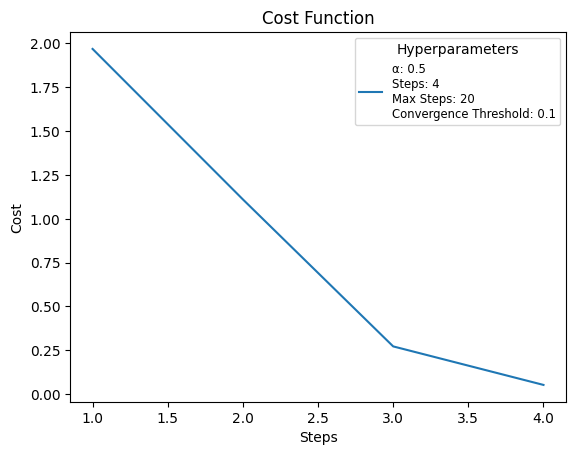

In [12]:
# Plot cost function
plt.plot(np.arange(1, steps+1), cost)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Cost Function')
plt.legend(labels=[f'α: {LEARNING_RATE}\nSteps: {steps}\nMax Steps: {MAX_STEPS}\nConvergence Threshold: {CONVERGENCE_THRESHOLD}'],
           title='Hyperparameters', fontsize='small')
plt.show()

## **Stage 3: Testing**

Use resulting trained angles in order to get the goal quantum state. This is done by applying the universal rotation gate with the trained angles as parameters.

In [13]:
# Print training results
theta_trained, phi_trained, lam_trained = trained[0], trained[1], trained[2]
x_trained = pauli_x(theta_trained, phi_trained, lam_trained)
y_trained = pauli_y(theta_trained, phi_trained, lam_trained)
z_trained = pauli_z(theta_trained, phi_trained, lam_trained)

print('Trained angles:\ntheta =', theta_trained, '\nphi =', phi_trained, '\nlam =', lam_trained)
print('\nTrained state:\nx =', x_trained, '\ny =', y_trained, '\nz =', z_trained)
print('\nDifferences (Goal - Trained):')
print(f'x = {x_goal - x_trained}')
print(f'y = {y_goal - y_trained}')
print(f'z = {z_goal - z_trained}')

Trained angles:
theta = 1.7804074783263077 
phi = -0.33256951986230066 
lam = -0.004711028834571789

Trained state:
x = 0.69775390625 
y = -0.08349609375 
z = -0.2939453125

Differences (Goal - Trained):
x = 0.20814368144665452
y = 0.005885769267510291
z = -0.12237931821394737


### Bloch Sphere Representation

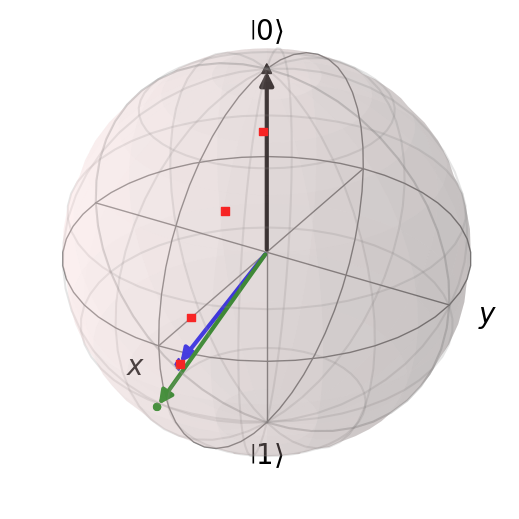

In [14]:
BlochSphere_trained = qt.Bloch()

# goal state
BlochSphere_trained.add_vectors([x_goal, y_goal, z_goal], colors=['green'])
BlochSphere_trained.add_points([x_goal, y_goal, z_goal], colors=['green'])
# intermediate states
BlochSphere_trained.add_points(states.T, colors=['red'] * steps)
# trained state
BlochSphere_trained.add_vectors([x_trained, y_trained, z_trained], colors=['blue'])
BlochSphere_trained.add_points([x_trained, y_trained, z_trained], colors=['blue'])
# ground state (initial state)
BlochSphere_trained.add_vectors([0,0,1], colors=['black'])
BlochSphere_trained.add_points([0,0,1], colors=['black'])

# Display BS & legend
BlochSphere_trained.show()
display_legend()